
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


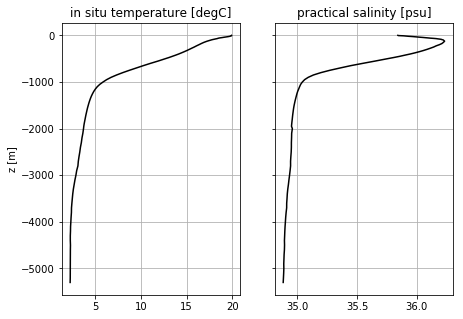

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

-3213.3 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 0.18 cm        - screw lead
  tick_per_turn  = 48.00 no dimension        - number o

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
#f.piston.update_d(f.piston.d+.001)
#f.piston_update_vol()
#print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m


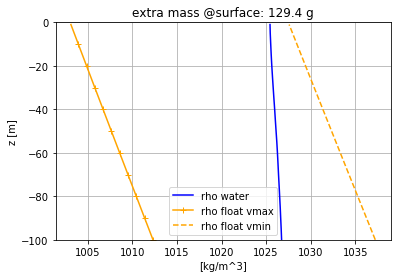

In [6]:
# show densities
plot_float_density(z, f, w)

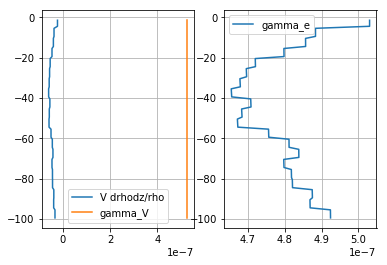

In [7]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [8]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [9]:
def plot_kalman(f):
    fig = plt.figure(figsize=(15,10))
    #
    ax=fig.add_subplot(231)
    ax.plot(f.log.t,f.log.z,'-', label = "real depth")
    ax.plot(f.t_kalman[1:],-f.log.z_kalman, label ="estimated depth")
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(232)
    ax.plot(f.log.t,f.log.w, label = "real velocity")
    ax.plot(f.t_kalman[1:],-f.log.w_kalman, label ="estimated velocity")
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(233)
    ax.plot(f.log.t,f.log.gammaV, label = "real equivalent compressibility")
    ax.plot(f.t_kalman[1:],f.log.gammaE_kalman, label ="estimated equivalent compressibility")
    ax.set_title("equivalent compressibility as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("gammaE (m^2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(234)
    ax.plot(f.log.t,f.log.Ve, label = "real Ve volume")
    ax.plot(f.t_kalman[1:],f.log.Ve_kalman, label ="estimated Ve volume")
    ax.set_title("volume Ve as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("Ve (m^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')   
    #
    ax=fig.add_subplot(235)
    ax.plot(f.log.t,-f.log.dwdt, label = "real acceleration")
    ax.plot(f.t_kalman[1:],f.log.dwdt_kalman, label ="estimated acceleration")
    ax.set_title("acceleration dw/dt as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("dw/dt (m.s^-2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    
    
    
    
def plot_regulation(f, vmax, nu, tau, delta):
    fig = plt.figure(figsize=(10,5))
    #
    ax=fig.add_subplot(121)
    ax.plot(f.log.t,f.log.z,'-', label = "depth")
    ax.set_title("depth as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    #
    ax=fig.add_subplot(122)
    ax.plot(f.log.t,f.log.w, label = "velocity")
    ax.set_title("velocity as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    # 

---

## Parameter estimation for feedback regulation

This notebook offers a way to estimate parameters for feedback regulation through the results of several simulations consisting in analyzing the command returned by the command law. The 3 parameter which will be estimated are : a time scale $\tau$, a characteristic velocity $\nu$, and a length scale $\delta$.


Let's set first $\tau$ at 1.0 s and try different pairs $(\nu, \delta)$ and assess their relevance according to a certain criterion.


The criterion will be the following: trying to regulate the float at a certain depth $\overline{z}$, the simulation will return a set of commands $u$ as a function of time, the pair $(\nu, \delta)$ will be approved only if all the values of $u$ returned during the simulation, belong to an interval $[u_{min}, u_{max}]$ where $u_{min}$ and $u_{max}$ are respectively the minimum and maximum reachable volume velocities.

A priori, $u_{min}$ and $u_{max}$ depend on the depth and on the bounds of the reachable volume rate values of the piston.

By fixing for example a depth target $\overline{z}$ of 25 m, the simulation will return a set of possible pairs $(\nu, \delta)$.

Then, let's choose $(\nu, \delta)$ among the possible values and change $\tau$ through another simulation. For each pair $(\nu, \delta)$ it can be considered that it exists several acceptable parameters $\tau$.

It can be considered for instance that each parameter $\tau$ is acceptable if after a long regulation time, the depth of the float $z$ belongs to the interval $[-(1.01)\overline{z}, (1.01)\overline{z}]$

Issue : how to compute $u_{min}$ and $u_{max}$.

---

## Feedback regulation without Kalman filter
### Regulation parameters : nu variable, tau and delta fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.006366197723675814
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.786692112888641
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1591.5494309189535
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done


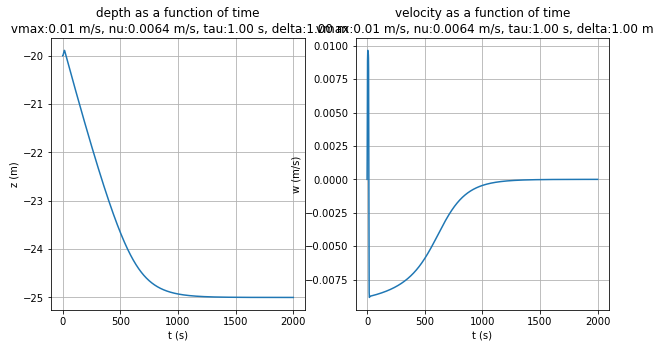

In [13]:
# time step float with control
vmax_reached = 0.01
nu = (2/np.pi)*vmax_reached
tau = 1.0 
delta = 1.0 

control = {'tau': tau, 'dz_nochattering': 0., 'mode': 'feedback', 'nu': nu, 'delta': delta}

#
f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=True, verbose=0)
plot_regulation(f, vmax_reached, nu, tau, delta)

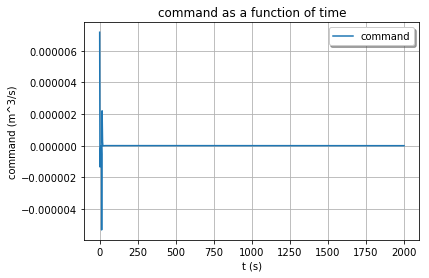

In [14]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.u, label ="command")
ax.set_title("command as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("command (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


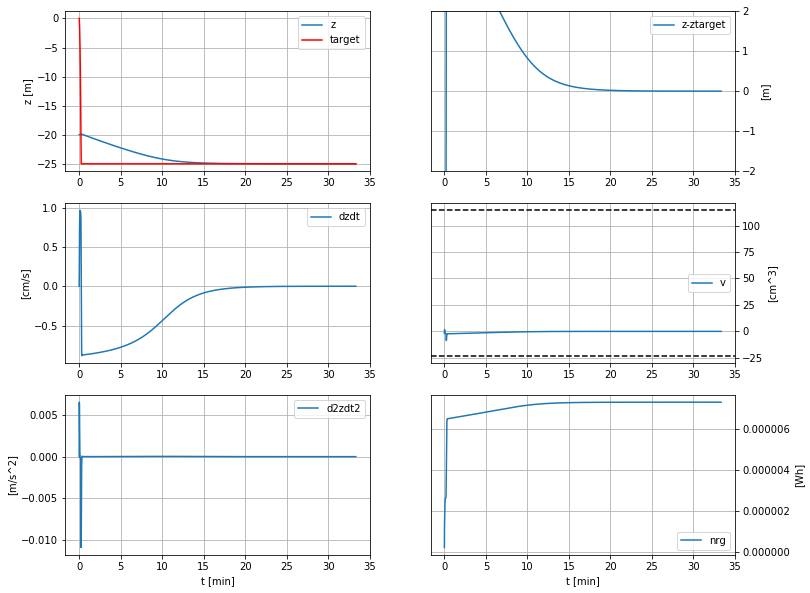

In [15]:
# plot log
plot_log(f,z_target=z_target)